## Logistic Regression
This notebook will use sklearn.linear_model.LogisticRegression to predict the status of pokemon.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### 0. Data Prep

In [2]:
df = pd.read_csv("./data/pokedex_enc.csv", index_col=0)

In [3]:
ycols = [c for c in df.columns if "status_" in c]
y = df.loc[:, ycols]
y.columns = [0, 1, 2, 3]
x = df.drop(ycols + ["pokedex_number", "name"], axis=1)
display(y.head())
display(x.head())

,0,1,2,3
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


,generation,type_number,height_m,weight_kg,abilities_number,total_points,hp,attack,defense,sp_attack,...,species_Wish Pokémon,species_Wolf Pokémon,species_Wood Gecko Pokémon,species_Woodpecker Pokémon,species_Wool Pokémon,species_Woolly Crab Pokémon,species_Worm Pokémon,species_Wrestling Pokémon,species_Young Fowl Pokémon,species_Zen Charm Pokémon
0,1,2,0.7,6.9,2,318.0,45.0,49.0,49.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,1.0,13.0,2,405.0,60.0,62.0,63.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,2.0,100.0,2,525.0,80.0,82.0,83.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2,2.4,155.5,1,625.0,80.0,100.0,123.0,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,0.6,8.5,2,309.0,39.0,52.0,43.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, shuffle=True)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, shuffle=True)
y_train, y_valid, y_test = y_train.idxmax(axis="columns"), y_valid.idxmax(axis="columns"), y_test.idxmax(axis="columns")

### 1. Base Model
This is a simple model to establish a baseline.

In [6]:
%%time
clf_base = LogisticRegression()
clf_base.fit(x_train, y_train)

Wall time: 74 ms


LogisticRegression()

In [7]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, f1_score

In [8]:
def getAccuracy(y_true, y_pred_proba, names, thresh, verbose=True):
    y_pred = (y_pred_proba > thresh).argmax(axis=1)
    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred_proba, multi_class="ovo")
    f1_w = f1_score(y_true, y_pred, average='weighted')
    f1_u = f1_score(y_true, y_pred, average='macro')
    if verbose:
        print(ycols)
        print(confusion)
        print(f"accuracy:\t\t{accuracy}\nroc:\t\t\t{roc}\nf1 (weighted):\t\t{f1_w}\nf1 (unweighted):\t{f1_u}")
    return {"accuracy": accuracy, "roc": roc, "f1_w": f1_w, "f1_u": f1_u, "confusion": confusion}

In [9]:
thresh = 0.5
y_pred = clf_base.predict_proba(x_valid)
base_acc = getAccuracy(y_valid, y_pred, ycols, thresh)

['status_Legendary', 'status_Mythical', 'status_Normal', 'status_Sub Legendary']
[[  5   0   0   1]
 [  1   3   1   0]
 [  0   1 136   0]
 [  1   0   2   3]]
accuracy:		0.9545454545454546
roc:			0.9626351716680185
f1 (weighted):		0.9517091604048126
f1 (unweighted):	0.7553511705685618


### 2. Hyperparameter Tuning

####  Threshold

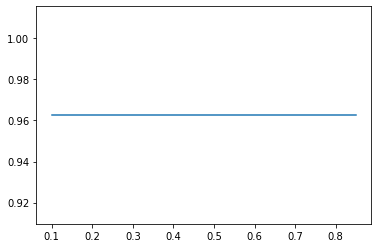

In [10]:
res = []
params = np.arange(0.1, 0.9, 0.05)
for thresh in params:
    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    y_pred = clf.predict_proba(x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, thresh, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

#### Max Iteration

c:\projects\pokepredict\venv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


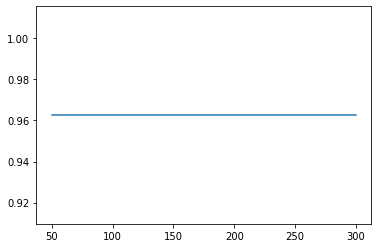

In [11]:
res = []
params = [50, 100, 150, 200, 250, 300]
for max_iter in params:
    clf = LogisticRegression(max_iter=max_iter)
    clf.fit(x_train, y_train)
    y_pred = clf.predict_proba(x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, thresh, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

#### Solver

c:\projects\pokepredict\venv\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\projects\pokepredict\venv\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


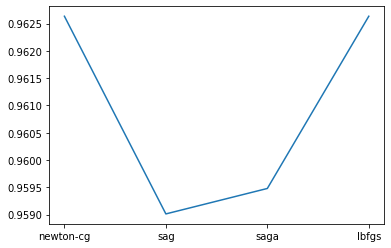

In [12]:
res = []
params = ["newton-cg", "sag", "saga", "lbfgs"]
for solver in params:
    clf = LogisticRegression(solver=solver)
    clf.fit(x_train, y_train)
    y_pred = clf.predict_proba(x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, thresh, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

### 3. Feature Selection

In [13]:
from sklearn.feature_selection import RFE

c:\projects\pokepredict\venv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\projects\pokepredict\venv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

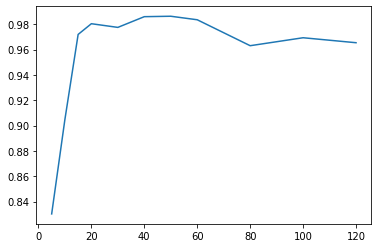

In [14]:
res = []
params = [5, 10, 15, 20, 30, 40, 50, 60, 80, 100, 120]
for n_feat in params:
    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    selector = RFE(clf, n_features_to_select=n_feat, step=0.8)
    selector = selector.fit(x_train, y_train)
    selector.fit(x_train, y_train)
    y_pred = selector.predict_proba(x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, thresh, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

In [15]:
selector = RFE(clf_base, n_features_to_select=30, step=1)
selector = selector.fit(x_train, y_train)
thresh = 0.5
y_pred = selector.predict_proba(x_valid)
selector_acc = getAccuracy(y_valid, y_pred, ycols, thresh, verbose=False)
print(selector_acc, base_acc)

c:\projects\pokepredict\venv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\projects\pokepredict\venv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

{'accuracy': 0.974025974025974, 'roc': 0.9638652338469856, 'f1_w': 0.9717782217782218, 'f1_u': 0.798076923076923, 'confusion': array([[  5,   1,   0,   0],
       [  2,   2,   0,   1],
       [  0,   0, 137,   0],
       [  0,   0,   0,   6]], dtype=int64)} {'accuracy': 0.9545454545454546, 'roc': 0.9626351716680185, 'f1_w': 0.9517091604048126, 'f1_u': 0.7553511705685618, 'confusion': array([[  5,   0,   0,   1],
       [  1,   3,   1,   0],
       [  0,   1, 136,   0],
       [  1,   0,   2,   3]], dtype=int64)}


c:\projects\pokepredict\venv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\projects\pokepredict\venv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 